# Explore flight delay data

This notebook replicates the month-delay relationship from NB1 while using general functions.

All categorical variables to predict delay time:
1. Month
2. Day of week 
3. Airline
4. Flight number 
5. Tail number
6. Origin airport 
7. Destination airport
8. scheduled departure hour
9. scheduled arrival hour

Continuous variables to predict delay time:
1. scheduled duration
2. distance


Delay time could be
* Calculate extra in-plane delay (ARRIVAL_DELAY - DEPARTURE_DELAY)
    * From this we could see which airlines speed up the most to make up for lost time
    * Maybe should account for delay by TAXI_OUT time
* Arrival_delay could be an extension in TAXI_IN, TAI_OUT, or AIR_TIME?
    * Reference based on the average TAXI_IN and TAXI_OUT time

In [1]:
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import pandas as pd

import seaborn as sns
sns.set_style('white')

In [2]:
import util

In [3]:
import imp
imp.reload(util)

<module 'util' from '/gh/flightdelay/nbsc/util.py'>

# Load data

In [4]:
df_al, df_ap, df_fl = util.load_data()

In [17]:
# Remove cancelled flights
df_fl = df_fl[np.isfinite(df_fl['DEPARTURE_DELAY'])]

In [18]:
print(len(df_fl))
df_fl.head()

5732926


,Unnamed: 0,Unnamed: 0.1,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,...,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY
0,0,0,2015,1,1,4,AS,98,N407AS,ANC,...,408.0,-22.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
1,1,1,2015,1,1,4,AA,2336,N3KUAA,LAX,...,741.0,-9.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
2,2,2,2015,1,1,4,US,840,N171US,SFO,...,811.0,5.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
3,3,3,2015,1,1,4,AA,258,N3HYAA,LAX,...,756.0,-9.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,4,4,2015,1,1,4,AS,135,N527AS,SEA,...,259.0,-21.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


In [19]:
print(df_fl.keys())

Index(['Unnamed: 0', 'Unnamed: 0.1', 'YEAR', 'MONTH', 'DAY', 'DAY_OF_WEEK',
       'AIRLINE', 'FLIGHT_NUMBER', 'TAIL_NUMBER', 'ORIGIN_AIRPORT',
       'DESTINATION_AIRPORT', 'SCHEDULED_DEPARTURE', 'DEPARTURE_TIME',
       'DEPARTURE_DELAY', 'TAXI_OUT', 'WHEELS_OFF', 'SCHEDULED_TIME',
       'ELAPSED_TIME', 'AIR_TIME', 'DISTANCE', 'WHEELS_ON', 'TAXI_IN',
       'SCHEDULED_ARRIVAL', 'ARRIVAL_TIME', 'ARRIVAL_DELAY', 'DIVERTED',
       'CANCELLED', 'CANCELLATION_REASON', 'AIR_SYSTEM_DELAY',
       'SECURITY_DELAY', 'AIRLINE_DELAY', 'LATE_AIRCRAFT_DELAY',
       'WEATHER_DELAY'],
      dtype='object')


# Relate airports to delays

In [20]:
key_predict = 'DEPARTURE_DELAY'
key_feature = 'ORIGIN_AIRPORT'

(-0.5, 40.5)

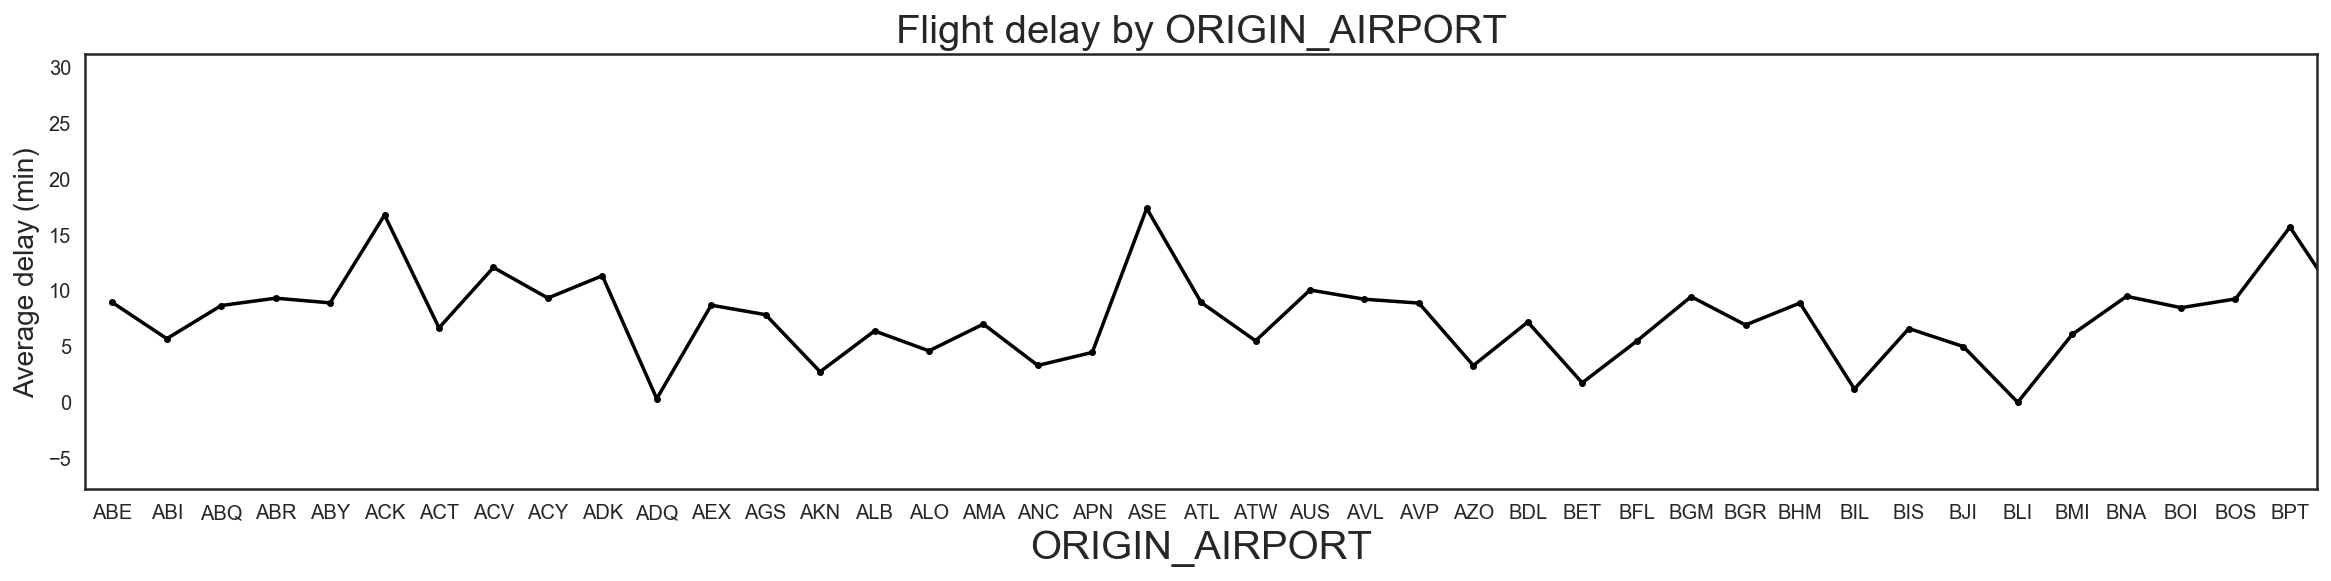

In [21]:
analysis_fn = util.relation_mean
analysis_kwargs = {}
plt.figure(figsize=(20,4))
delay_by_airport_mean, all_airports, N_airports = util.relation_explorer(df_fl, key_predict, key_feature,
                      analysis_fn = analysis_fn, analysis_kwargs = analysis_kwargs,
                                    return_all_x = True, return_N_x = True)
plt.xlabel(key_feature,size=20)
plt.ylabel('Average delay (min)', size=14)
plt.title('Flight delay by '+key_feature,size=20)
plt.xlim((-.5,40.5))

# Determine the most and least delayed airports

In [22]:
# Determine airport ranking
airport_idxsort = np.argsort(delay_by_airport_mean)

In [23]:
# Load the name of the airport
df_airportinfo = pd.DataFrame.from_csv('/gh/data/flightdelay/L_AIRPORT.csv')
dict_airportinfo = dict(zip(df_airportinfo.index,df_airportinfo['Description']))

In [24]:
# Calculate number of flights at each airport
all_airports2, Nflights_by_airport = np.unique(df_fl[key_feature].values,return_counts=True)

In [25]:
# List best 10 airports (least delayed)
topN = 40
for i in range(topN):
    airport_ID = all_airports[airport_idxsort[i]]
    mean_delay = delay_by_airport_mean[airport_idxsort[i]]
    Nflights = Nflights_by_airport[airport_idxsort[i]]
    airport_name = dict_airportinfo[airport_ID]
    print(format(mean_delay,'.1f'),airport_ID, format(Nflights,'6.0f'),'flights', airport_name)

-6.1 YAK    719 flights Yakutat, AK: Yakutat Airport
-6.1 CNY    205 flights Moab, UT: Canyonlands Field
-3.9 EKO    570 flights Elko, NV: Elko Regional
-3.7 VEL    200 flights Vernal, UT: Vernal Regional
-3.5 CDV    715 flights Cordova, AK: Merle K Mudhole Smith
-3.1 LWS    641 flights Lewiston, ID: Lewiston Nez Perce County
-1.8 PIH    709 flights Pocatello, ID: Pocatello Regional
-1.0 ITO   6214 flights Hilo, HI: Hilo International
-0.9 TWF    894 flights Twin Falls, ID: Joslin Field - Magic Valley Regional
-0.1 SCC    917 flights Deadhorse, AK: Deadhorse Airport
-0.1 BLI    709 flights Bellingham, WA: Bellingham International
0.1 BTM    709 flights Butte, MT: Bert Mooney
0.3 ADQ    465 flights Kodiak, AK: Kodiak Airport
0.3 BRD    635 flights Brainerd, MN: Brainerd Lakes Regional
0.6 DLG     77 flights Dillingham, AK: Dillingham Airport
0.6 LIH  11386 flights Lihue, HI: Lihue Airport
0.7 IDA   2431 flights Idaho Falls, ID: Idaho Falls Regional
0.7 GTF   2142 flights Great Falls, MT

In [27]:
# List best 10 airports (least delayed)
topN = 40
print('Delay (min).')
for i in range(1,topN+1):
    airport_ID = all_airports[airport_idxsort[-i]]
    mean_delay = delay_by_airport_mean[airport_idxsort[-i]]
    Nflights = Nflights_by_airport[airport_idxsort[-i]]
    airport_name = dict_airportinfo[airport_ID]
    print(format(mean_delay,'.1f'),airport_ID, format(Nflights,'6.0f'),'flights', airport_name)

Delay (min).
29.4 ILG     97 flights Wilmington, DE: New Castle
24.7 MVY    216 flights Martha's Vineyard, MA: Martha's Vineyard Airport
23.2 HYA     82 flights Hyannis, MA: Barnstable Municipal-Boardman/Polando Field
20.8 PPG    116 flights Pago Pago, TT: Pago Pago International
19.0 OTH    297 flights North Bend/Coos Bay, OR: Southwest Oregon Regional
18.7 STC     78 flights St. Cloud, MN: St. Cloud Regional
17.4 CEC    174 flights Crescent City, CA: Jack McNamara Field
17.3 ASE   3348 flights Aspen, CO: Aspen Pitkin County Sardy Field
17.2 GST     76 flights Gustavus, AK: Gustavus Airport
16.7 ACK    514 flights Nantucket, MA: Nantucket Memorial
15.7 EGE   1209 flights Eagle, CO: Eagle County Regional
15.7 BPT    996 flights Beaumont/Port Arthur, TX: Jack Brooks Regional
15.2 GUM    361 flights Guam, TT: Guam International
15.0 UST    158 flights St. Augustine, FL: Northeast Florida Regional
14.6 ITH     30 flights Ithaca/Cortland, NY: Ithaca Tompkins Regional
13.9 COU   1372 flight

In [29]:
# Look up an airport's average delay
airport = 'SAN'
print(delay_by_airport_mean[np.argwhere(all_airports==airport)[0][0]])
print(Nflights_by_airport[np.argwhere(all_airports==airport)[0][0]])

7.97826259421
75630


In [35]:
np.mean(Nflights_by_airport)/365

48.778405513485922

(array([ 101.,   54.,   31.,   18.,   12.,   12.,    9.,    7.,    3.,
           4.,    4.,    2.,    2.,    3.,    2.,    2.,    3.,    2.,
           0.,    1.,    3.,    1.,    1.,    0.,    0.,    2.,    0.,
           1.,    0.,    2.,    0.,    0.,    3.,    2.,    0.,    0.,
           2.,    1.,    0.,    0.,    3.,    0.,    0.,    0.,    1.,
           0.,    0.,    0.,    0.,    0.,    0.,    1.,    0.,    0.,
           1.,    0.,    1.,    0.,    0.,    1.,    1.,    0.,    2.,
           0.,    0.,    0.,    0.,    0.,    1.,    0.,    0.,    0.,
           0.,    1.,    0.,    0.,    0.,    0.,    0.,    1.,    0.,
           0.,    1.,    0.,    1.,    0.,    2.,    0.,    0.,    0.,
           0.,    1.,    0.,    1.,    1.,    0.,    1.,    1.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    1.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    1.,
      

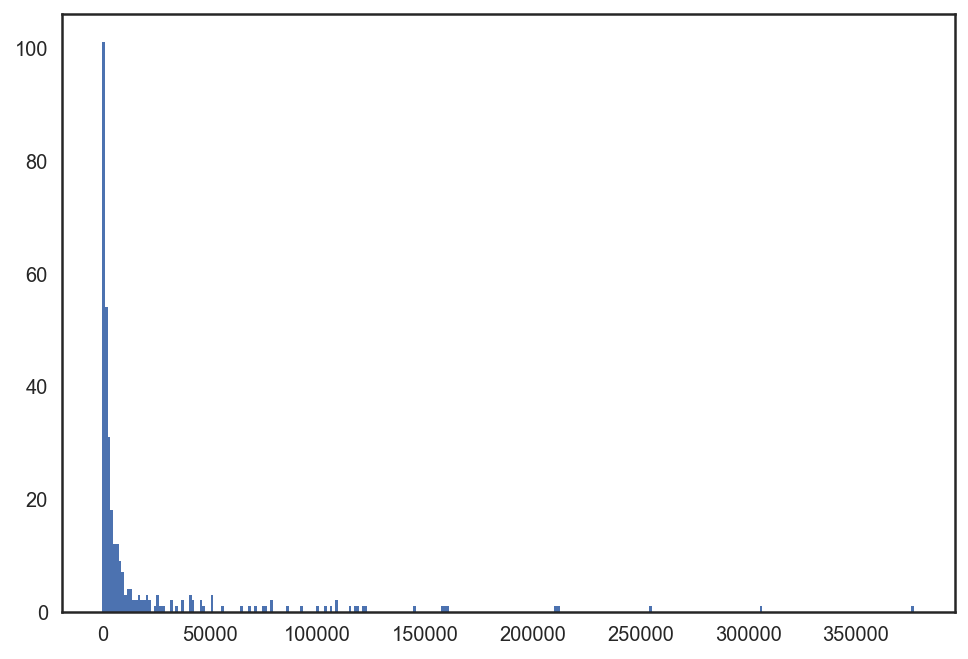

In [37]:
# Plot distribution of #flights
plt.hist(Nflights_by_airport,bins=300)

In [39]:
sum(Nflights_by_airport>3650*2)

96

In [41]:
70000/365

191.78082191780823